## Graph neural networks: Use machine learning to find a shortest path in weighted directed graphs

Consider a directed graph $G=(V,E)$ with $V = \{1, \dots, n\}$ and $E=\{(s_i, r_i, w_i)\mid i=1,\dots, m\}$ where $s_i, r_i \in V$ are sender and receiver nodes for edge $i$ and $w_i$ is a positive weight. Let the length of a path $e_1, \dots, e_k \in E$ be defined as $L(s,t) = \sum_{e_i} w_i$. We can assume that the graph is connected.

Goal: Design a simple graph neural network that finds a shortest path between two given nodes $s, t \in V$ in a given graph. 

Below you will find code that
- generates random graphs and converts them to training examples and targets
- visualizes a graph
- implements a simple graph neural network that can be used to predict shortest path probabilities for edges

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import spatial

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#for reproducibilty 
np.random.seed(0)
tf.random.set_seed(0)

In [27]:
# a method that generates a connected weighted random graph and finds a
# shortest path between two random nodes in this graph
def make_graph(n_min = 10, n_max=20, p_edge=0.1):
    
    #number of nodes in the generated graph
    num_nodes = np.random.randint(n_min, n_max)

    # use networkx to sample a geographic threshold graph.
    rand_graph = nx.fast_gnp_random_graph(num_nodes, p_edge)
    
    # sample a random tree
    rand_tree = nx.generators.trees.random_tree(num_nodes)
    
    # compose graph and tree to make sure the returned graph will always be connected
    G = nx.compose_all((rand_graph, rand_tree))
    G = G.to_directed()
    
    #generate 2D positions for all nodes in the graph
    pos = nx.spring_layout(G)
    pos_array = np.array([pos[i] for i in range(num_nodes)])
    
    #compute all pairwise euclidean distances
    distances = spatial.distance.cdist(pos_array, pos_array)
    
    #create a target graph; it will have different attributes than G
    G_target = G.copy()
    
    # put all distance weights into edge attributes.
    for i, j in G.edges():
        G.get_edge_data(i, j).setdefault(
                "distance", distances[i, j])
        G.get_edge_data(j, i).setdefault(
                "distance", distances[j, i])
        
    # here we take the 2 nodes with the greatest distance as start and target
    s,t = np.unravel_index(np.argmax(distances), distances.shape)
    if s==t: #bad case, just sample again
        make_graph(n_min, n_max, p_edge)
    nx.set_node_attributes(G, False, "start") #default case
    nx.set_node_attributes(G, {s:True}, "start") 
    nx.set_node_attributes(G, False, "target") #default case
    nx.set_node_attributes(G, {t:True}, "target") 
    
    #compute a shortest path and add attributes to G_target
    shortest_path = nx.shortest_path(G, s, t, weight="distance")
    
    nx.set_edge_attributes(G_target, 
                           False, 
                           "shortest_path") #default case
    nx.set_edge_attributes(G_target, 
                           {(i,j):True for i,j in zip(shortest_path[:-1], shortest_path[1:])}, 
                           "shortest_path")
    
    return G, G_target, pos


#draws a graph, optionally adds a given shortest path with colors
def draw_graph(G, G_target, pos, edge_widths=1.0):
    plt.rcParams["figure.figsize"] = (16,10)
    node_colors = ["green" if s
                   else
                        "orange" if t
                               else "blue" 
                   for (_,s),(_,t) in zip(G.nodes.data("start"), G.nodes.data("target"))]
    edge_colors = ["red" if p else (0,0,0,0) #< non shortest path edges are transparent
                   for _,_,p in G_target.edges.data("shortest_path")]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors)
    nx.draw_networkx_edges(G, 
                           pos, 
                           width=edge_widths, 
                           connectionstyle="arc3,rad=0.1") #draw all edges in black
    nx.draw_networkx_edges(G_target, 
                           pos, 
                           edge_color=edge_colors, 
                           width=edge_widths,
                           connectionstyle="arc3,rad=0.1") #only draw shortest path edges in red on top
    plt.show()

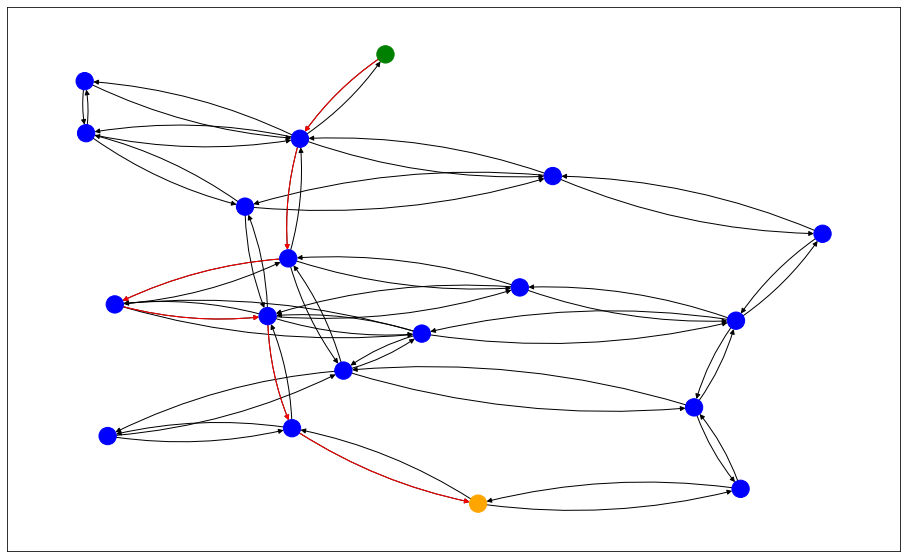

In [28]:
draw_graph(*make_graph())

## Formatting the input

The next step will be to take a nx.Graph object and convert it into a numeric format interpretable by a machine learning model. In our case, we have

- input edge properties: the (euclidean) distance between two nodes
- input node properties: classes "start", "finish" and "other"
- output edge properties: binary labels that are $1$ if and only if the edge is part of a shortest path

Let $V$ be a $n\times 3$ matrix with a one hot encoding of the 3 input classes and $E$ be a $m\times 1$ vector with the distances of all edges.

We want to predict $P(e \in P^* \mid V, E)$ for all edges $e$ and a shortest path $P^*$.

In [112]:
#train on small graphs for speed
NUM_NODES_TRAIN = (7,18)
#test on larger graphs to validate generalization
NUM_NODES_VAL = (18,30) 
BATCH_SIZE = 8


def convert_graph_to_input_target(G, G_target):
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    input_nodes = np.zeros((n, 3))
    input_nodes[:,1] = [s for _,s in G.nodes.data("start")]
    input_nodes[:,2] = [t for _,t in G.nodes.data("target")]
    input_nodes[:,0] = 1 - input_nodes[:,1] - input_nodes[:,2]
    
    input_edges = np.zeros((m, 1))
    input_edges[:,0] = [d for _,_,d in G.edges.data("distance")]
    
    path_probs = np.zeros((m, 1))
    path_probs[:,0] = [p for _,_,p in G_target.edges.data("shortest_path")]
    
    incidence_matrix = nx.incidence_matrix(G, oriented=True)
    
    #scipy sparse matrix to tensorflow spare matrix
    coo = incidence_matrix.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    
    input_dict = {
        "input_nodes" : input_nodes,
        "input_edges" : input_edges,
        "incidence_matrix_sender_indices" : indices[coo.data == 1],
        "incidence_matrix_receiver_indices" : indices[coo.data == -1]
    }
    target_dict =  {
        "path_probs" : path_probs
    }
    return input_dict, target_dict


# we do not use a global property in our graph
# therefore, we can simply merge all graphs in a batch into a large graph 
# message passing without a global property is independet for connected components
def sample_batch(num_nodes_minmax, batch_size=BATCH_SIZE, draw=False):
    batch_graphs = []
    batch_target_graphs = []
    batch_pos = {}
    n = 0
    div = int(np.sqrt(batch_size))
    for i in range(batch_size):
        g,gt,pos = make_graph(*num_nodes_minmax)
        mapping = {j : n+j for j in pos}
        g = nx.relabel_nodes(g, mapping)
        gt = nx.relabel_nodes(gt, mapping)
        batch_graphs.append(g)
        batch_target_graphs.append(gt)
        offset = np.array([i%div, i/div])
        batch_pos.update({n+j : offset*3+p for j,p in pos.items()})
        n += g.number_of_nodes()
    batch_graph = nx.compose_all(batch_graphs)
    batch_target_graph = nx.compose_all(batch_target_graphs)
    if draw:
        draw_graph(batch_graph, batch_target_graph, batch_pos)
    return convert_graph_to_input_target(batch_graph, batch_target_graph)


class SampleGenerator(keras.utils.Sequence):

    def __init__(self, num_nodes_minmax, epoch_len):
        self.num_nodes_minmax = num_nodes_minmax
        self.epoch_len = epoch_len

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def __getitem__(self, _index):
        return sample_batch(self.num_nodes_minmax)
    

train_gen = SampleGenerator(NUM_NODES_TRAIN, 500)
val_gen = SampleGenerator(NUM_NODES_VAL, 10)

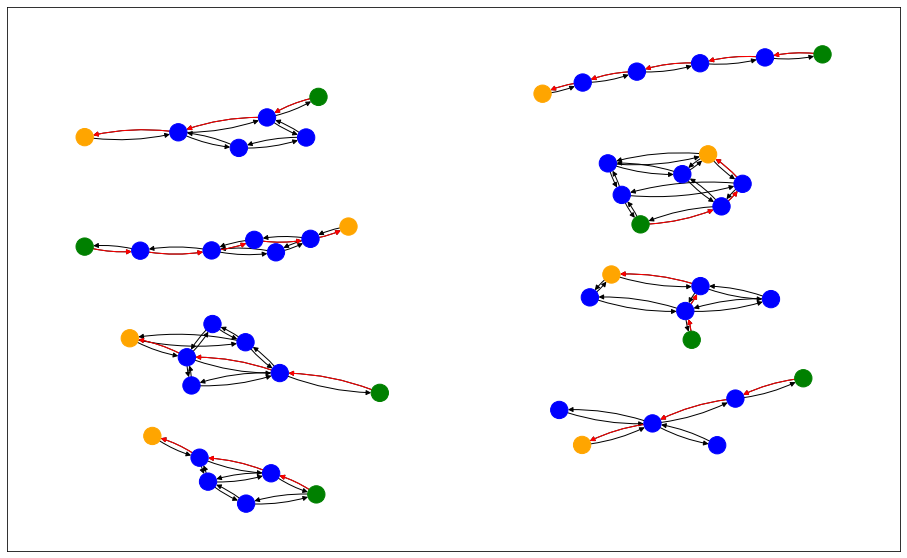

In [113]:
_=sample_batch((5,8), batch_size=8, draw=True)

Note: The y axis was scaled to display the graphs and therefore s and t may look like not being the 2 nodes with the largest euclidean distance although in fact they are.

## Define the network

Here we use simple 2 layer MLPs with relu activations followed by a layer normalization as message/update functions.

The GNN gets $n$ nodes, $m$ edges and incidence matrices as input.

In [114]:
#a feedforward layer
def make_ff_layer(config):
    return keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(config["latent_dim"]),
            layers.LayerNormalization()])

def make_GNN(config):
    
    #define the inputs
    #note: keras inputs have their batch size omitted in "shape"
    V = keras.Input(shape=(3), name="input_nodes") 
    E = keras.Input(shape=(1), name="input_edges") 
    Isi = keras.Input(shape=(2), name="incidence_matrix_sender_indices", dtype=tf.int64) 
    Iri = keras.Input(shape=(2), name="incidence_matrix_receiver_indices", dtype=tf.int64) 
    
    dense_shape = (tf.shape(V)[0], tf.shape(E)[0])
    Is = tf.SparseTensor(Isi, 
                         tf.ones(tf.shape(Isi)[0]), 
                         dense_shape)
    Ir = tf.SparseTensor(Iri, 
                         tf.ones(tf.shape(Isi)[0]), 
                         dense_shape)
    
    Is_T = tf.sparse.transpose(Is)
    Ir_T = tf.sparse.transpose(Ir)
    
    #step 1: encode
    #transform each node (dim=3) and edge (dim=1) to a latent embedding of "latent_dim"
    node_encoder = make_ff_layer(config)
    edge_encoder = make_ff_layer(config)
    V_enc = node_encoder(V)
    E_enc = edge_encoder(E)
    
    #step 2: message passing
    node_updater = make_ff_layer(config)
    edge_updater = make_ff_layer(config)
    for _ in range(config["message_passing_iterations"]):
        
        #for each node, sum outgoing and incoming edges (separately)
        V_Es = tf.sparse.sparse_dense_matmul(Is, E_enc) 
        V_Er = tf.sparse.sparse_dense_matmul(Ir, E_enc)
        #update all nodes based on current state and aggregated edge states
        V_concat = tf.concat([V_enc, V_Es, V_Er], axis=-1)
        V_enc = node_updater(V_concat)
        
        #get states of respective sender and receiver nodes for each edge
        E_Vs = tf.sparse.sparse_dense_matmul(Is_T, V_enc)
        E_Vr = tf.sparse.sparse_dense_matmul(Ir_T, V_enc)
        #update all edges
        E_concat = tf.concat([E_enc, E_Vs, E_Vr], axis=-1)
        E_enc = edge_updater(E_concat)
        
    #step 3: decode
    #in this case, we want to predict for each edge the probability of lying on a shortest path
    #we use sigmoid as activation
    edge_decoder = layers.Dense(1, activation="sigmoid")
    path_probs = edge_decoder(E_enc)
    
    model = keras.Model(inputs=[V, E, Isi, Iri], 
                        outputs=[layers.Lambda(lambda x: x, name="path_probs")(path_probs)])

    return model    

## Training

In [116]:
config = {
    "message_passing_iterations" : 10,
    "latent_dim" : 32
}

NUM_EPOCHS = 10


GNN = make_GNN(config)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

GNN.compile(loss="binary_crossentropy", 
            optimizer=optimizer, 
            metrics="binary_accuracy")

#takes ~10min on GPU
#change config for quick results on CPU 
history = GNN.fit(train_gen,
                    validation_data=val_gen,
                    epochs = NUM_EPOCHS,
                    verbose = 1)

Epoch 1/10
500/500 [==============================] - 17s 34ms/step - loss: 0.1838 - binary_accuracy: 0.9248 - val_loss: 0.0842 - val_binary_accuracy: 0.9683
Epoch 2/10
500/500 [==============================] - 17s 33ms/step - loss: 0.1179 - binary_accuracy: 0.9474 - val_loss: 0.0844 - val_binary_accuracy: 0.9665
Epoch 3/10
500/500 [==============================] - 17s 33ms/step - loss: 0.1053 - binary_accuracy: 0.9531 - val_loss: 0.0807 - val_binary_accuracy: 0.9683
Epoch 4/10
500/500 [==============================] - 17s 33ms/step - loss: 0.0993 - binary_accuracy: 0.9556 - val_loss: 0.0745 - val_binary_accuracy: 0.9672
Epoch 5/10
500/500 [==============================] - 16s 33ms/step - loss: 0.0917 - binary_accuracy: 0.9589 - val_loss: 0.0731 - val_binary_accuracy: 0.9678
Epoch 6/10
500/500 [==============================] - 17s 33ms/step - loss: 0.0909 - binary_accuracy: 0.9598 - val_loss: 0.0695 - val_binary_accuracy: 0.9704
Epoch 7/10
500/500 [==============================] 

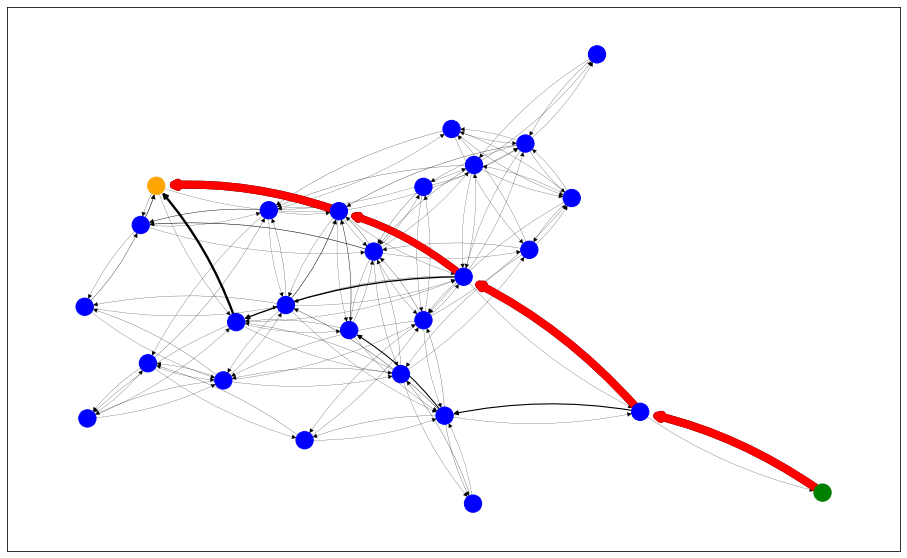

In [127]:
g, gt, pos = make_graph(18, 30)
inp, tar = convert_graph_to_input_target(g, gt)
path_probs = GNN(inp)

#thick edges correspond to large probabilities
#red edges mark the correct shortest path
#if multiple short paths with similar lengths exists, the model gets confused
#works well if the shortest path is unique
draw_graph(g, gt, pos, 0.2 + 8*path_probs)

# Question
Describe an approach that could fix the problem that occurs with multiple shortest paths in one graph.
Tip: Describe how to iteratively apply the trained model to the problem.